In [29]:
# In this notebook two type of experiments are considered
# - pure    -> experiments with one simultaneously running MPI task 
# - sharing -> experiments with two simultaneously running MPI tasks

# This experiments may be
# local  -> VMs connect between each other with local linux bridge 
# or
# remote -> VMs connect between each other with remote linux bridge

# Results for max 16 threads
RESULTS_PATH = {
    "pure": "../results/pure_NPB_local/cluster",
    "sharing": {
        "cluster_1": "../results/sharing_NPB_size_A_local/cluster_1",
        "cluster_2": "../results/sharing_NPB_size_A_local/cluster_2"
    }
}

# Results for max 32 threads
RESULTS_PATH = {
    "pure": "../results/pure_NPB_local_32//cluster",
    "sharing": {
        "cluster_1": "../results/sharing_NPB_size_A_local_32//cluster_1",
        "cluster_2": "../results/sharing_NPB_size_A_local_32//cluster_2"
    }
}



In [30]:
# Pure experiments

import os
import json
import pandas as pd
from tabulate import tabulate
from collections import OrderedDict


def get_comp_time_pure(results_dir, tasks, sizes, procs, experiments_num):
    """This function parse results file and return computational statistics

    Args:
        results_dir (str): directory with result files.
            Each file has name with following pattern:
            <exec file name>_<task size>_<number of MPI procs>_e_<experiment seq num>.out
            
            Ex:
                lu.W.x_W_8_e_1.out

    Returns:
        dict: key   - task name 
              value - dict with
                  key   - task size
                  value - dict with
                      key   - number of proc
                      value - average computational time

    """
    
    if not os.path.isdir(results_dir):
        raise "Cannot find directory ''%s'" % results_dir
        
    results = {}
    
    for task in tasks:
        if task not in results:
            results[task] = OrderedDict()

        for size in sizes:
            if size not in results[task]:
                results[task][size] = OrderedDict()
            
            for proc in procs:
                if proc not in results[task][size]:
                    results[task][size][proc] = list()

                filename = "%s.%s.x_%s_%s" % (task, size, size, proc)
                for n in range(0, experiments_num):
                    full_path = os.path.join(results_dir, "%s_e_%d.out" % (filename, n))
                    if not os.path.isfile(full_path):
                        results[task][size][proc].append(float("nan"))
                    else:
                        with open(full_path, "r") as f:
                            line = f.readline()
                            while line != "":
                                if "Time in seconds" in line:
                                    results[task][size][proc].append(float(line.split('=')[1]))
                                    break
                                line = f.readline()

                if len(results[task][size][proc]) != 0:
                    results[task][size][proc] = sum(results[task][size][proc]) / float(len(results[task][size][proc]))
                else:
                    results[task][size][proc] = float("nan")

    return results

def print_comp_time_pure(comp_time, tasks):
    for task in tasks:
        df = pd.DataFrame(comp_time[task])
        print("Results for task '%s'" % (task))
        print(df)
        print('\n')

def get_resources_usage():
    # TODO
    pass


# ============================================================

# Read and print computational time
tasks = ["is", "ep", "cg", "lu", "ft"]
sizes = ["S", "W", "A", "B", "C", "D"]
# procs = [1, 2, 4, 8, 16]
procs = [1, 2, 4, 8, 16, 32]# NOTE! For 32 threads only
exp_num = 5

results_pure = get_comp_time_pure(RESULTS_PATH["pure"],
                                  tasks, sizes, procs, exp_num)

# print(json.dumps(results, sort_keys = True, indent = 4))
print_comp_time_pure(results_pure, tasks)


# Read and print information about resources usage
res_usage = get_resources_usage()


Results for task 'is'
        S      W      A      B      C   D
1   0.000  0.070  0.978  3.854    NaN NaN
2   0.008  0.062  0.620  2.560    NaN NaN
4   0.010  0.040  0.368  1.432  6.150 NaN
8   0.010  0.028  0.256  0.888  3.846 NaN
16  0.014  0.038  0.206  0.754  2.922 NaN
32  0.868  0.942  1.148  1.996  4.446 NaN


Results for task 'ep'
        S      W       A       B        C         D
1   0.832  1.638  12.238  48.322  191.332  3013.194
2   0.466  0.860   6.342  24.860   98.136  1590.954
4   0.264  0.492   3.430  13.120   51.398   834.448
8   0.138  0.300   1.856   7.122   28.026   446.764
16  0.092  0.172   1.118   4.140   16.198   260.558
32  0.114  0.148   0.772   2.818   10.752   167.102


Results for task 'cg'
         S       W       A       B        C   D
1    0.042   0.254   0.992     NaN      NaN NaN
2    0.076   0.222   0.574  45.900      NaN NaN
4    0.080   0.168   0.410  32.182   95.502 NaN
8    0.122   0.190   0.346  12.198   46.342 NaN
16   0.206   0.260   0.400  16.8

In [31]:
# Sharing experiments
# We have checked yet sharing effect only on tasks with size A
# slowdown coefficient = time with sharing / pure time

# Names of result files
# pure
#     ep.B.x_B_16_e_0.out

# sharing 
#     ep.A.x_ep.A.x_8_4_e_0.out
#     ep.A.x_ep.A.x_8_16.out

from functools import reduce
from copy import deepcopy


def get_comp_time_sharing(dir1, dir2, tasks, procs, experiments_num):
    """This function parse results file and return computational statistics

    Args:
        dir1 and dir2 (str): directory with result files for cluster_1 and cluster_2
            Each file has name with following pattern:
            <exec file name 1>_<exec file name 2>_<number of MPI procs 1>_<number of MPI procs 2>_e_<experiment seq num>.out
            
            Ex:
                lu.A.x_lu.A.x_8_8_e_3.out

    Returns:
        dict: key   - tuple with two task names
              value - dict with
                  key   - tuple with np1, np2, where np is number of processes
                  value - tuple with two corresponding computational times

    """
    
    if not os.path.isdir(dir1):
        raise "Cannot find directory ''%s'" % dir1
        
    if not os.path.isdir(dir2):
        raise "Cannot find directory ''%s'" % dir2
        
    results = {}
    
    for i in range(0, len(tasks)):
        for j in range(i, len(tasks)):
            key_1 = tuple((tasks[i], tasks[j]))
            if key_1 not in results:
                results[key_1] = OrderedDict()

            for np1 in procs:
                for np2 in procs:
#                     print("RUN (%s, %s) (%s, %s)" % (tasks[i], tasks[j], np1, np2))
                    
#                     key_2 = str(np1) + ' ' + str(np2)
                    key_2 = tuple((np1, np2))
                    if key_2 not in results[key_1]:
                        results[key_1][key_2] = list()
                    
                    filename_1 = "%s.A.x_%s.A.x_%s_%s" % (tasks[i], tasks[j], np1, np2)
                    filename_2 = "%s.A.x_%s.A.x_%s_%s" % (tasks[j], tasks[i], np2, np1)
            
                    for n in range(0, experiments_num):
                        full_path_1 = os.path.join(dir1, "%s_e_%d.out" % (filename_1, n))
                        full_path_2 = os.path.join(dir2, "%s_e_%d.out" % (filename_2, n))
                        
                        t1 = float("nan")
                        t2 = float("nan")
                        
                        if os.path.isfile(full_path_1):
                            with open(full_path_1, "r") as f:
                                line = f.readline()
                                while line != "":
                                    if "Time in seconds" in line:
                                        t1 = float(line.split('=')[1])
                                        break
                                    line = f.readline()
                        
                        if os.path.isfile(full_path_2):
                            with open(full_path_2, "r") as f:
                                line = f.readline()
                                while line != "":
                                    if "Time in seconds" in line:
                                        t2 = float(line.split('=')[1])
                                        break
                                    line = f.readline()
                        
                        results[key_1][key_2].append([t1, t2])

                    if len(results[key_1][key_2]) != 0:
                        t1_sum = reduce(lambda a,b: a+b[0], results[key_1][key_2], 0)

                        t2_sum = reduce(lambda a,b: a+b[1], results[key_1][key_2], 0)
                        
                        results[key_1][key_2] = tuple((t1_sum / float(len(results[key_1][key_2])),
                                                       t2_sum / float(len(results[key_1][key_2]))))
                    else:
                        results[key_1][key_2] = tuple((float("nan"), float("nan")))
                    
    return results


def print_comp_time_sharing(comp_time, tasks):
    for i in range(0, len(tasks)):
        for j in range(i, len(tasks)):
            df = pd.DataFrame(comp_time[(tasks[i], tasks[j])])
            print("Results for pair (%s, %s)" % (tasks[i], tasks[j]))
            print(df)
            print('\n')

# ============================================================

# Read and print computational time
tasks = ["is", "ep", "cg", "lu", "ft"]
# procs = [4, 8, 16]
procs = [4, 8, 16, 32] # NOTE! For 32 thread only
exp_num = 1

results_sharing = get_comp_time_sharing(
            RESULTS_PATH["sharing"]["cluster_1"],
            RESULTS_PATH["sharing"]["cluster_2"],
            tasks, procs, exp_num)

print("Computational results for sharing experiments".upper())
print_comp_time_sharing(results_sharing, tasks)

# results for pure computation for all tasks with size A
print("Computational results for pure run for all tasks with size A".upper())
for task, task_res in results_pure.items():
    print("Results for '%s'" % task)
    df = pd.DataFrame(task_res)
    print(df['A'], '\n')

COMPUTATIONAL RESULTS FOR SHARING EXPERIMENTS
Results for pair (is, is)
     4                      8                       16                    \
     4     8     16   32    4     8     16    32    4     8     16    32   
0  0.63  0.57  0.49  1.8  0.84  0.48  0.37  2.13  0.59  0.29  0.33  2.19   
1  0.39  0.35  0.30  1.6  0.44  0.46  0.30  1.92  0.40  0.42  0.30  2.36   

     32                    
     4     8     16    32  
0  2.13  1.44  1.66  2.00  
1  0.41  0.30  0.26  2.48  


Results for pair (is, ep)
     4                       8                       16                   \
     4     8     16    32    4     8     16    32    4    8     16    32   
0  0.40  0.47  0.49  1.59  0.35  0.34  0.35  1.26  0.25  0.3  0.88  1.00   
1  3.73  2.03  1.26  1.14  3.76  2.09  1.30  1.17  3.89  2.1  1.36  1.54   

     32                    
     4     8     16    32  
0  1.87  1.86  1.33  1.34  
1  4.53  2.75  1.39  1.41  


Results for pair (is, cg)
     4                        8       

In [32]:
# Slowdown
# slowdown coefficient = time with sharing divided on pure time
print("Slowdown information".upper())

slowdown_info = deepcopy(results_sharing)
for tasks_pair, procs in slowdown_info.items():
    for procs_pair, t in procs.items():
        t1_p = results_pure[tasks_pair[0]]["A"][procs_pair[0]]
        t2_p = results_pure[tasks_pair[1]]["A"][procs_pair[1]]
        print("(%s,%s) (%2s,%2s) sharing: (%f,%f); pure: (%f,%f); slowdown: (%f,%f)" % 
              (tasks_pair[0], tasks_pair[1], procs_pair[0], procs_pair[1], 
               t[0], t[1], t1_p, t2_p, t[0]/t1_p, t[1]/t2_p))
        
        slowdown_info[tasks_pair][procs_pair] = tuple((t[0]/t1_p , t[1]/t2_p))

SLOWDOWN INFORMATION
(ft,ft) ( 4, 4) sharing: (5.630000,2.010000); pure: (1.674000,1.674000); slowdown: (3.363202,1.200717)
(ft,ft) ( 4, 8) sharing: (2.270000,1.450000); pure: (1.674000,1.088000); slowdown: (1.356033,1.332721)
(ft,ft) ( 4,16) sharing: (1.980000,0.960000); pure: (1.674000,0.838000); slowdown: (1.182796,1.145585)
(ft,ft) ( 4,32) sharing: (5.070000,6.240000); pure: (1.674000,3.106000); slowdown: (3.028674,2.009015)
(ft,ft) ( 8, 4) sharing: (1.760000,1.860000); pure: (1.088000,1.674000); slowdown: (1.617647,1.111111)
(ft,ft) ( 8, 8) sharing: (1.790000,1.720000); pure: (1.088000,1.088000); slowdown: (1.645221,1.580882)
(ft,ft) ( 8,16) sharing: (1.670000,1.140000); pure: (1.088000,0.838000); slowdown: (1.534926,1.360382)
(ft,ft) ( 8,32) sharing: (7.080000,7.440000); pure: (1.088000,3.106000); slowdown: (6.507353,2.395364)
(ft,ft) (16, 4) sharing: (1.950000,1.940000); pure: (0.838000,1.674000); slowdown: (2.326969,1.158901)
(ft,ft) (16, 8) sharing: (1.320000,1.780000); pure: 

In [33]:
# Print slowdown info
print("Slowdown results for sharing experiments".upper())
print_comp_time_sharing(slowdown_info, tasks)

print(list(slowdown_info[('is', 'is')].keys()))
print(list(slowdown_info[('is', 'is')].values()))

SLOWDOWN RESULTS FOR SHARING EXPERIMENTS
Results for pair (is, is)
         4                                       8                       \
         4         8         16        32        4         8         16   
0  1.711957  1.548913  1.331522  4.891304  3.281250  1.875000  1.445312   
1  1.059783  1.367187  1.456311  1.393728  1.195652  1.796875  1.456311   

                   16                                       32            \
         32        4         8         16         32        4         8    
0  8.320312  2.864078  1.407767  1.601942  10.631068  1.855401  1.254355   
1  1.672474  1.086957  1.640625  1.456311   2.055749  1.114130  1.171875   

                       
         16        32  
0  1.445993  1.742160  
1  1.262136  2.160279  


Results for pair (is, ep)
         4                                       8                       \
         4         8         16        32        4         8         16   
0  1.086957  1.277174  1.331522  4.320652  1.367187  

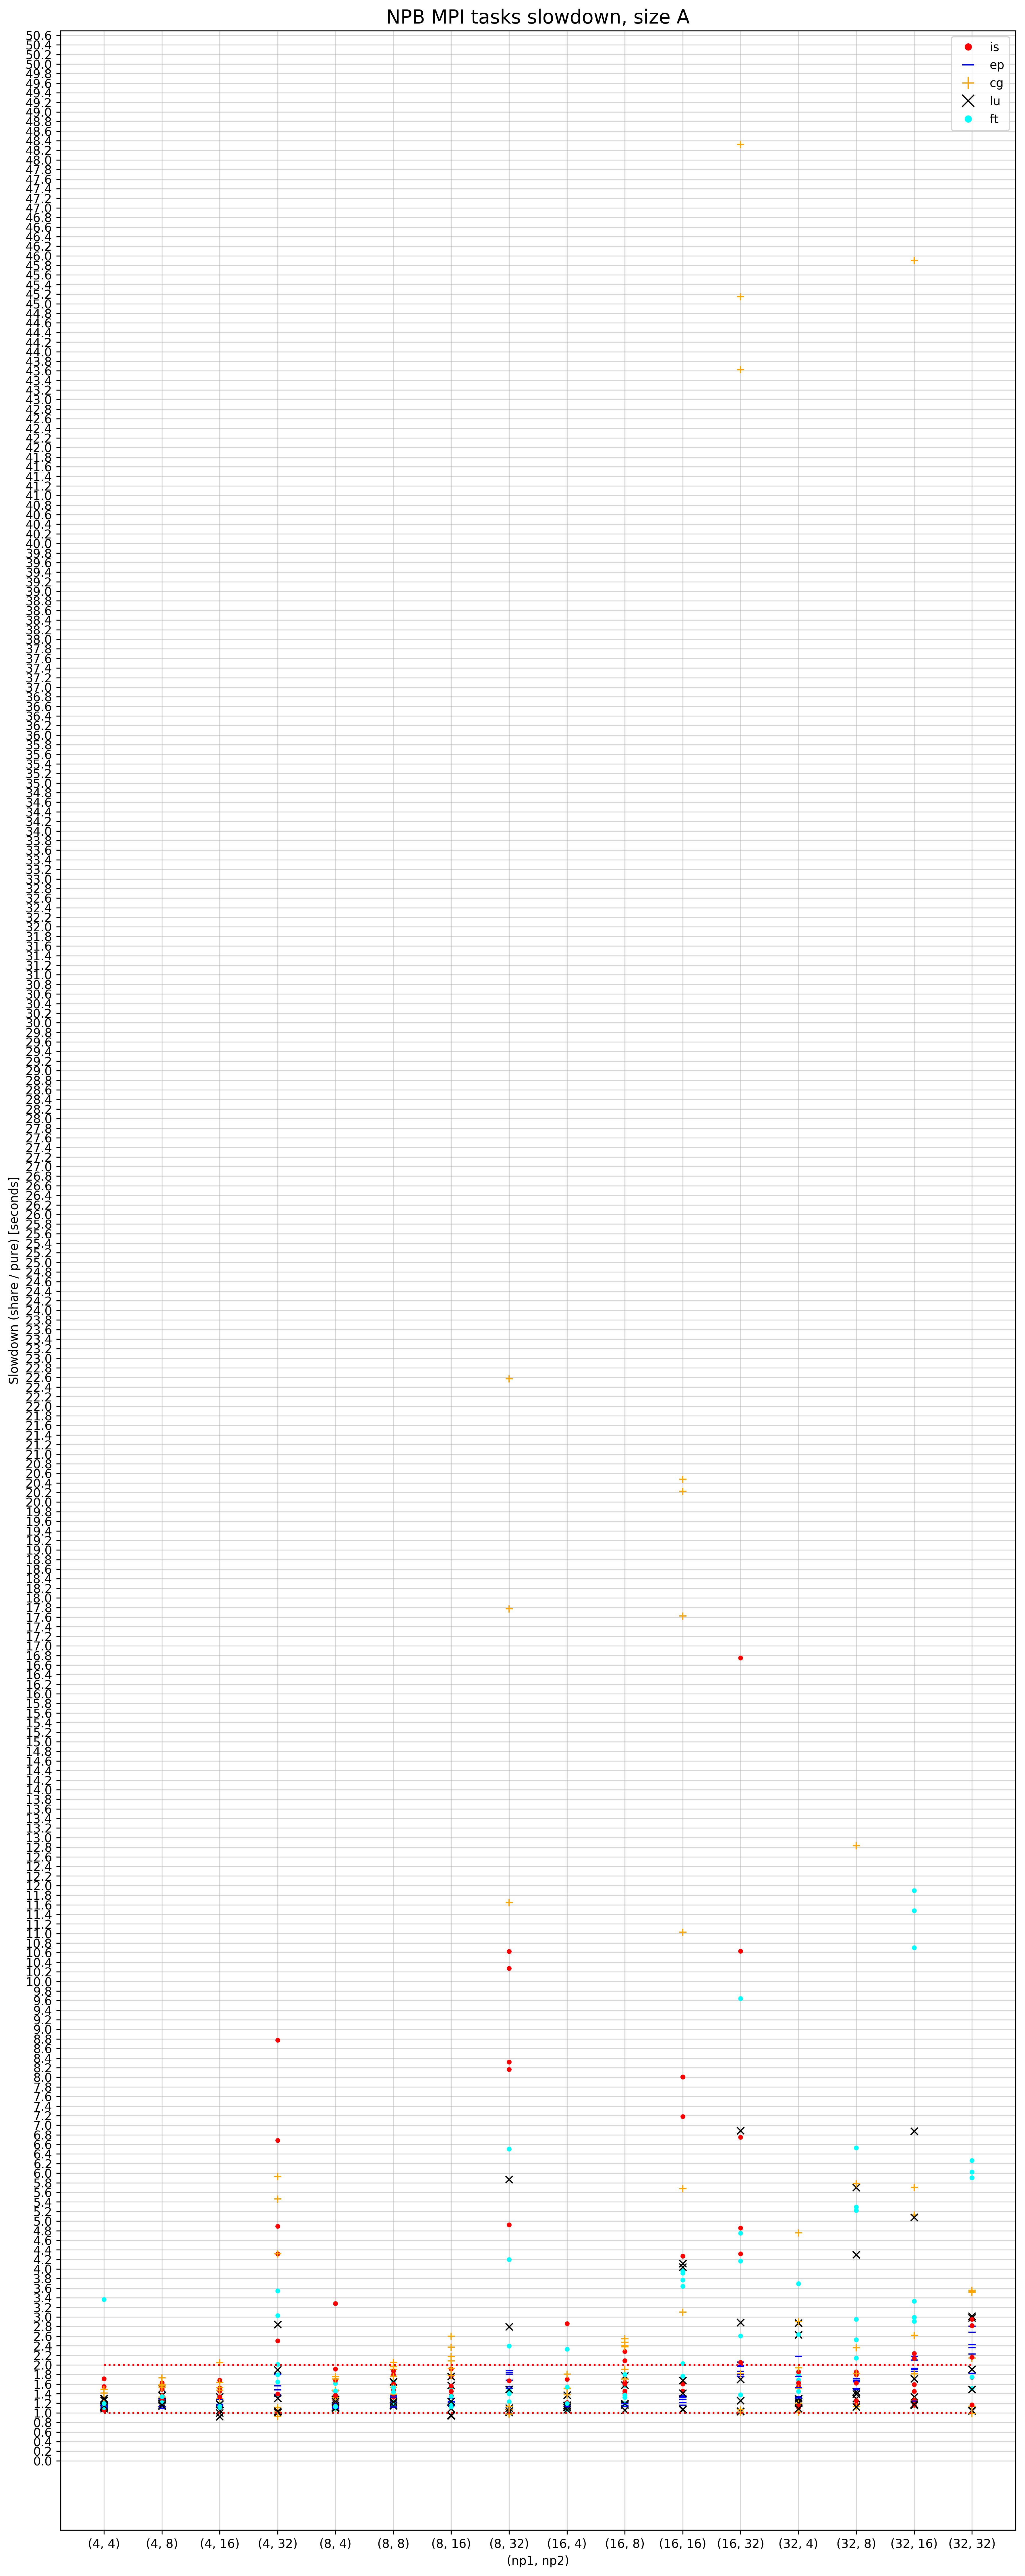

In [34]:
# Draw slowdown info

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
%matplotlib inline


tasks = ["is", "ep", "cg", "lu", "ft"]
colors = {"is": "red", "ep": "blue", "cg": "orange", "lu": "black", "ft": "cyan"}
markers = {"is": ".", "ep": "_", "cg": "+", "lu": "x", "ft": "."}

# Figure configuration
fig = plt.figure(figsize=(12,30), dpi=300)
ax = fig.add_subplot(111)
plt.title('NPB MPI tasks slowdown, size A', fontsize=16)

# Draw
for tasks_pair, procs in slowdown_info.items():
    n = 0
    for procs_pair, sl in procs.items():
        task1 = tasks_pair[0]
        task2 = tasks_pair[1]
        sl1 = sl[0]
        sl2 = sl[1]
        
        ax.plot(n, sl1, color=colors[task1], marker=markers[task1])
        ax.plot(n, sl2, color=colors[task2], marker=markers[task2])
        
        n += 1

# Draw slowdown lines with factor 1 and 2
null_slowdown_x = np.linspace(0, len(slowdown_info[('is', 'is')].keys())-1, num=2)
null_slowdown_y = np.zeros(2)
ax.plot(null_slowdown_x, null_slowdown_y+1, color="red", linestyle=":")

ax.plot(null_slowdown_x, null_slowdown_y+2, color="red", linestyle=":")

# Axes configuration
ax.set_xticks(np.arange(len(slowdown_info[('is', 'is')].keys())))
ax.set_xticklabels(list(slowdown_info[('is', 'is')].keys()))
ax.set_xlabel("(np1, np2)")
ax.set_ylabel("Slowdown (share / pure) [seconds]")


# Grid configuration
stepsize = 0.2
start, end = ax.get_ylim()
ax.yaxis.set_ticks(np.arange(0, end, stepsize))

ax.set_axisbelow(True)
ax.grid(which='both')
ax.grid(which='major', alpha=0.5)

# Form legend
legend_elements = []
for task in tasks:
    legend_elements.append(
        Line2D([], [], marker=markers[task], color=colors[task], linestyle='None', label=task, markersize=10))

# Show figure
ax.legend(handles=legend_elements)
plt.tight_layout()
plt.show()
fig.savefig('./slowdown_size_A.png', fmt='png')
plt.close(fig)
# plt.gcf().clear()

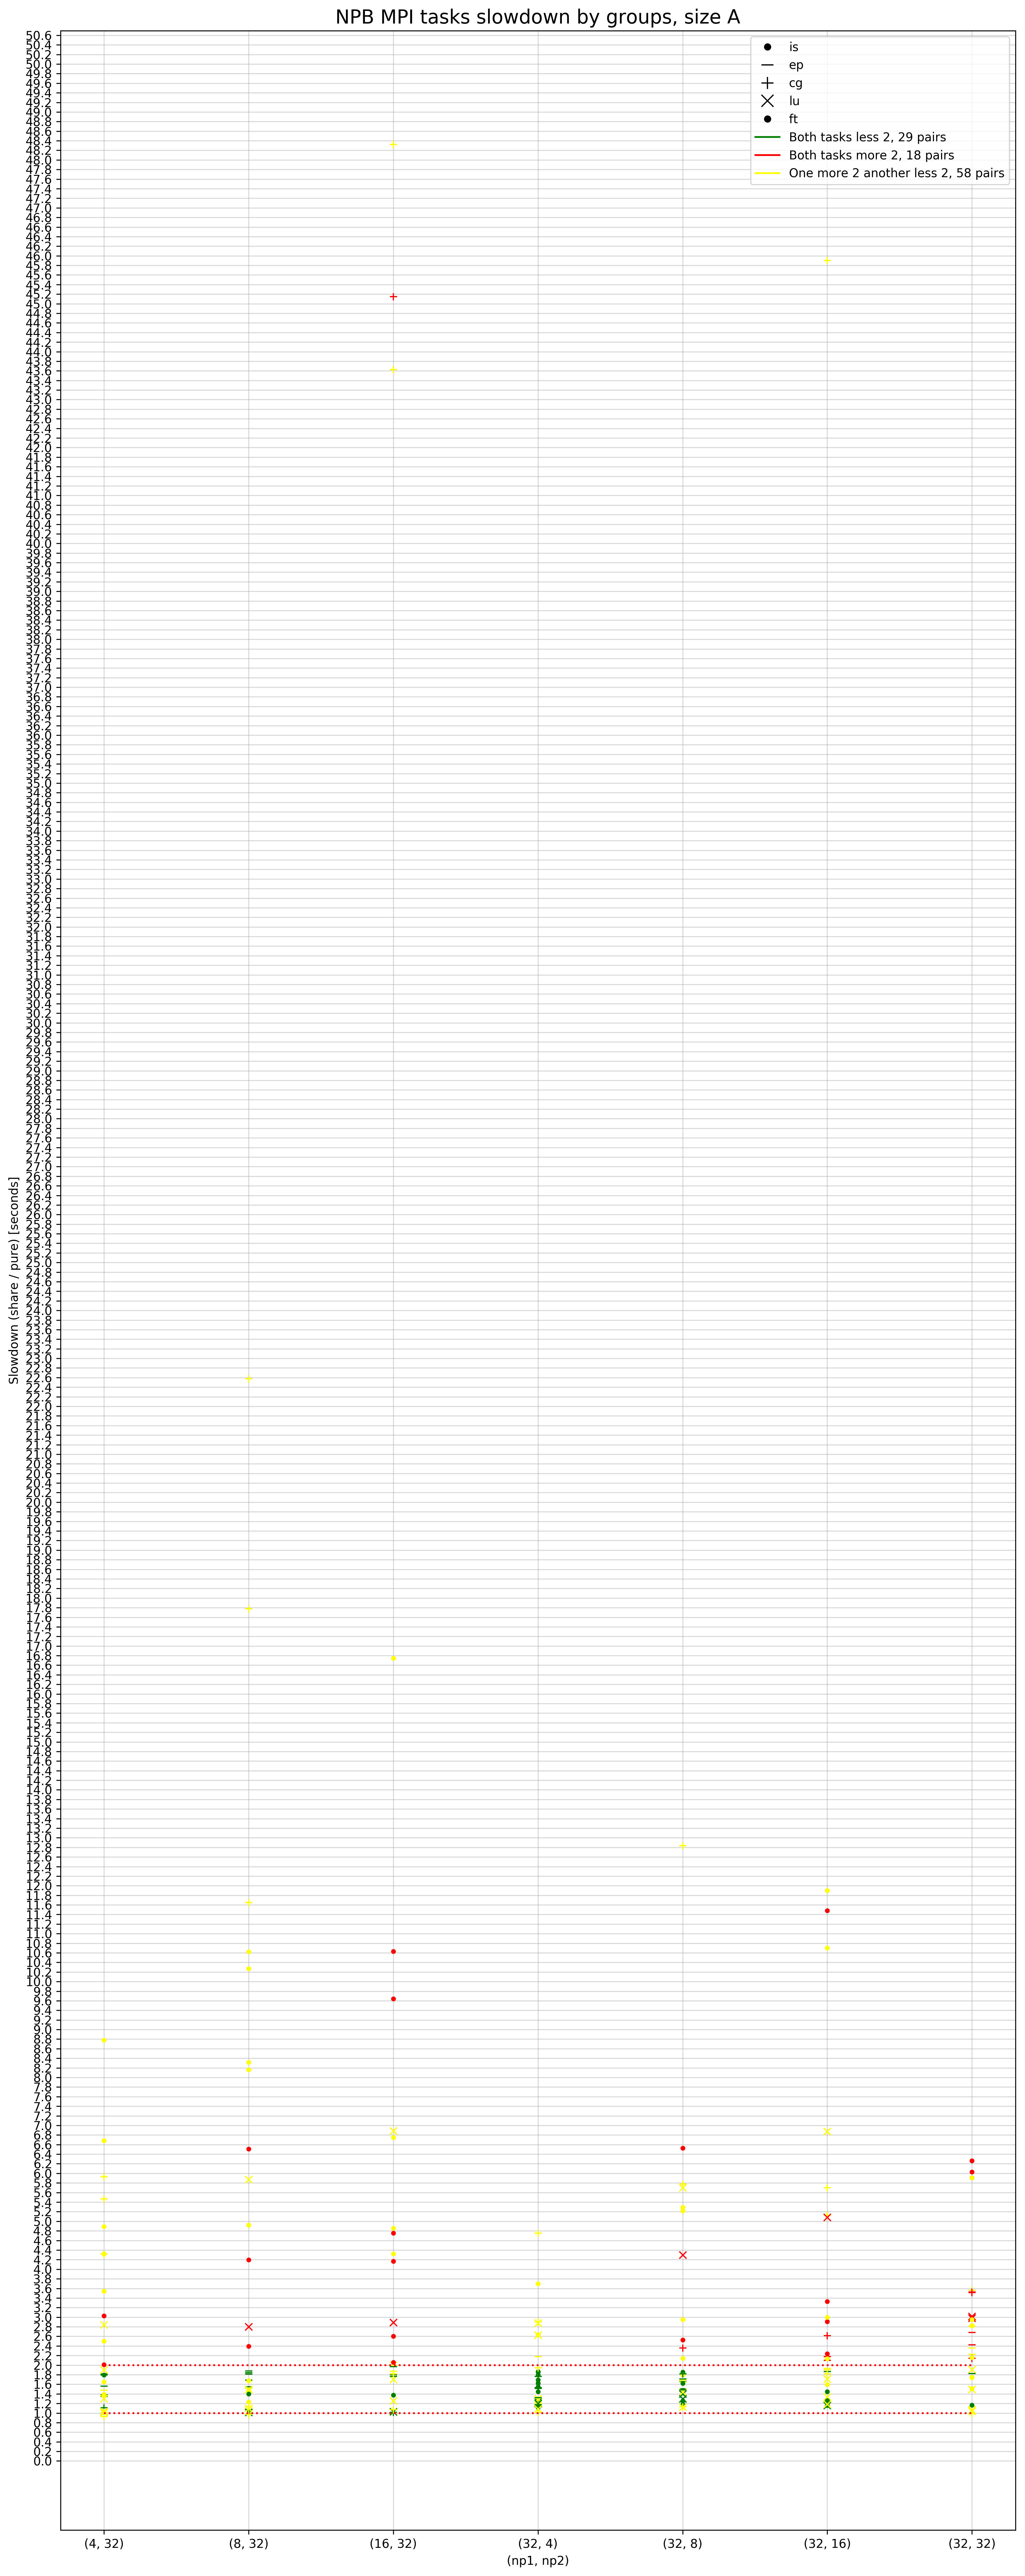

In [38]:
# Draw slowdown info
# Marked tasks whose slowdown coefficient in [1,2]
# If both tasks in pair have slowdown coefficient more than 2 -> red
# If one tasks in pair have slowdown coefficient more than 2, another less than 2 -> yellow
# If both tasks in pair have slowdown coefficient less than 2 -> green

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
%matplotlib inline


tasks = ["is", "ep", "cg", "lu", "ft"]
colors = {"is": "red", "ep": "blue", "cg": "orange", "lu": "black", "ft": "cyan"}
markers = {"is": ".", "ep": "_", "cg": "+", "lu": "x", "ft": "."}

# Figure configuration
fig = plt.figure(figsize=(12,30), dpi=300)
ax = fig.add_subplot(111)
plt.title('NPB MPI tasks slowdown by groups, size A', fontsize=16)

# Draw
# X_DOTS = [2, 5, 6, 7, 8] # index int list [(4,4), (4,8), ..., (16,16)]
X_DOTS = [3, 7, 11, 12, 13, 14, 15] # NOTE! For 32 threads only

green = 0
red = 0
yellow = 0

for tasks_pair, procs in slowdown_info.items():
    n = -1
    for procs_pair, sl in procs.items():
        n += 1
        if (n not in X_DOTS):
            continue
        
        task1 = tasks_pair[0]
        task2 = tasks_pair[1]
        sl1 = sl[0]
        sl2 = sl[1]
        
        color = "black"
        if sl1 < 2 and sl2 < 2:
            color = "green"
            green += 1
        elif sl1 >= 2 and sl2 >= 2:
            color = "red"
            red += 1
        else:
            color = "yellow"
            yellow += 1
            
        ax.plot(X_DOTS.index(n), sl1, color=color, marker=markers[task1])
        ax.plot(X_DOTS.index(n), sl2, color=color, marker=markers[task2])

# Draw slowdown lines with factor 1 and 2
PROCS_PAIR = list(slowdown_info[('is', 'is')].keys())
null_slowdown_x = np.linspace(0, len(X_DOTS)-1, num=2)
null_slowdown_y = np.zeros(2)
ax.plot(null_slowdown_x, null_slowdown_y+1, color="red", linestyle=":")

ax.plot(null_slowdown_x, null_slowdown_y+2, color="red", linestyle=":")

# Axes configuration
ax.set_xticks(np.arange(len(X_DOTS)))
ax.set_xticklabels([PROCS_PAIR[i] for i in X_DOTS])
ax.set_xlabel("(np1, np2)")
ax.set_ylabel("Slowdown (share / pure) [seconds]")


# Grid configuration
stepsize = 0.2
start, end = ax.get_ylim()
ax.yaxis.set_ticks(np.arange(0, end, stepsize))

ax.set_axisbelow(True)
ax.grid(which='both')
ax.grid(which='major', alpha=0.5)

# Form legend
legend_elements = []
for task in tasks:
    legend_elements.append(
        Line2D([], [], marker=markers[task], color="black", linestyle='None', label=task, markersize=10))

legend_elements.append(
        Line2D([0], [0], color="green", linestyle='-', label="Both tasks less 2, %d pairs" % green))
legend_elements.append(
        Line2D([0], [0], color="red", linestyle='-', label="Both tasks more 2, %d pairs" % red))
legend_elements.append(
        Line2D([0], [0], color="yellow", linestyle='-', label="One more 2 another less 2, %d pairs" % yellow))

# Show figure
ax.legend(handles=legend_elements)
plt.tight_layout()
plt.show()
fig.savefig('./slowdown_size_A_groups_%s.png' % str('_'.join(map(str, X_DOTS))), fmt='png')
plt.close(fig)
# plt.gcf().clear()

In [40]:
# Divide tasks in six groups, see comments in above cell

# GROUP 1: [0,1] [0,1]
# GROUP 2: [1,2] [1,2]
# GROUP 3: [2,inf] [2,inf]
# GROUP 4: [0,1] [1,2]
# GROUP 5: [0,1] [2,inf]
# GROUP 6: [1,2] [2,inf]

print("Divide tasks in six groups".upper())

slowdown_groups = OrderedDict([
    ("GROUP 1: [0,1) [0,1)", []),
    ("GROUP 2: [1,2) [1,2)", []),
    ("GROUP 3: [2,inf) [2,inf)", []),
    ("GROUP 4: [0,1] [1,2] or [1,2] [0,1]", []),
    ("GROUP 5: [0,1] [2,inf] or [2,inf] [0,1]", []),
    ("GROUP 6: [1,2] [2,inf] or [2,inf] [1,2]", [])
])


sum_group_sizes = 0

procs_required = [16]
# procs_limit = 16 # number of processes without sharing
procs_limit = 32 # NOTE! For 32 thread only

for tasks_pair, procs in slowdown_info.items():
    for procs_pair, t in procs.items():
#         print("(%s,%s) (%2s,%2s) ; slowdown: (%f,%f)" % 
#               (tasks_pair[0], tasks_pair[1], procs_pair[0], procs_pair[1], t[0], t[1]))

        if (procs_pair[0] + procs_pair[1]) <= procs_limit:
            continue
#         if not (procs_pair[0] in procs_required or procs_pair[1] in procs_required):
#             continue

        if t[0] >= 0 and t[0] < 1 and t[1] >= 0 and t[1] < 1:
            slowdown_groups["GROUP 1: [0,1) [0,1)"].append((tasks_pair, procs_pair, t))
            sum_group_sizes += 1

        if t[0] >= 1 and t[0] < 2 and t[1] >= 1 and t[1] < 2:
            slowdown_groups["GROUP 2: [1,2) [1,2)"].append((tasks_pair, procs_pair, t))
            sum_group_sizes += 1
            
        if t[0] >= 2 and t[1] >= 2:
            slowdown_groups["GROUP 3: [2,inf) [2,inf)"].append((tasks_pair, procs_pair, t))
            sum_group_sizes += 1
            
        if (t[0] >= 0 and t[0] <= 1 and t[1] >= 1 and t[1] <= 2) or \
           (t[1] >= 0 and t[1] <= 1 and t[0] >= 1 and t[0] <= 2):
            slowdown_groups["GROUP 4: [0,1] [1,2] or [1,2] [0,1]"].append((tasks_pair, procs_pair, t))
            sum_group_sizes += 1
            
        if (t[0] >= 0 and t[0] <= 1 and t[1] >= 2) or \
           (t[1] >= 0 and t[1] <= 1 and t[0] >= 2):
            slowdown_groups["GROUP 5: [0,1] [2,inf] or [2,inf] [0,1]"].append((tasks_pair, procs_pair, t))
            sum_group_sizes += 1

        if (t[0] >= 1 and t[0] <= 2 and t[1] >= 2) or \
           (t[1] >= 1 and t[1] <= 2 and t[0] >= 2):
            slowdown_groups["GROUP 6: [1,2] [2,inf] or [2,inf] [1,2]"].append((tasks_pair, procs_pair, t))
            sum_group_sizes += 1
            

for name, group in slowdown_groups.items():
    print("%s, group size -> %d" % (name, len(group)))
    for member in group:
        print("\t%s" % str(member))
        
print("Summary group sizes -> %d" % sum_group_sizes)

DIVIDE TASKS IN SIX GROUPS
GROUP 1: [0,1) [0,1), group size -> 0
GROUP 2: [1,2) [1,2), group size -> 29
	(('ft', 'ft'), (32, 4), (1.796522858982614, 1.8637992831541217))
	(('ep', 'ep'), (4, 32), (1.381924198250729, 1.3471502590673574))
	(('ep', 'ep'), (8, 32), (1.5463362068965516, 1.6839378238341969))
	(('ep', 'ep'), (32, 8), (1.7098445595854923, 1.5086206896551722))
	(('is', 'lu'), (32, 4), (1.6202090592334493, 1.2373649355176017))
	(('is', 'lu'), (32, 8), (1.8554006968641112, 1.395677900694623))
	(('ep', 'lu'), (4, 32), (1.7930029154518954, 1.0336496477848285))
	(('ep', 'lu'), (8, 32), (1.8103448275862066, 1.012982476567503))
	(('ep', 'lu'), (16, 32), (1.7620751341681573, 1.027536822495197))
	(('ep', 'lu'), (32, 4), (1.761658031088083, 1.199895433949111))
	(('ep', 'lu'), (32, 8), (1.6580310880829014, 1.2966297916130691))
	(('ep', 'lu'), (32, 16), (1.8652849740932642, 1.1609607951408063))
	(('is', 'is'), (32, 4), (1.8554006968641112, 1.1141304347826086))
	(('is', 'is'), (32, 8), (1.25

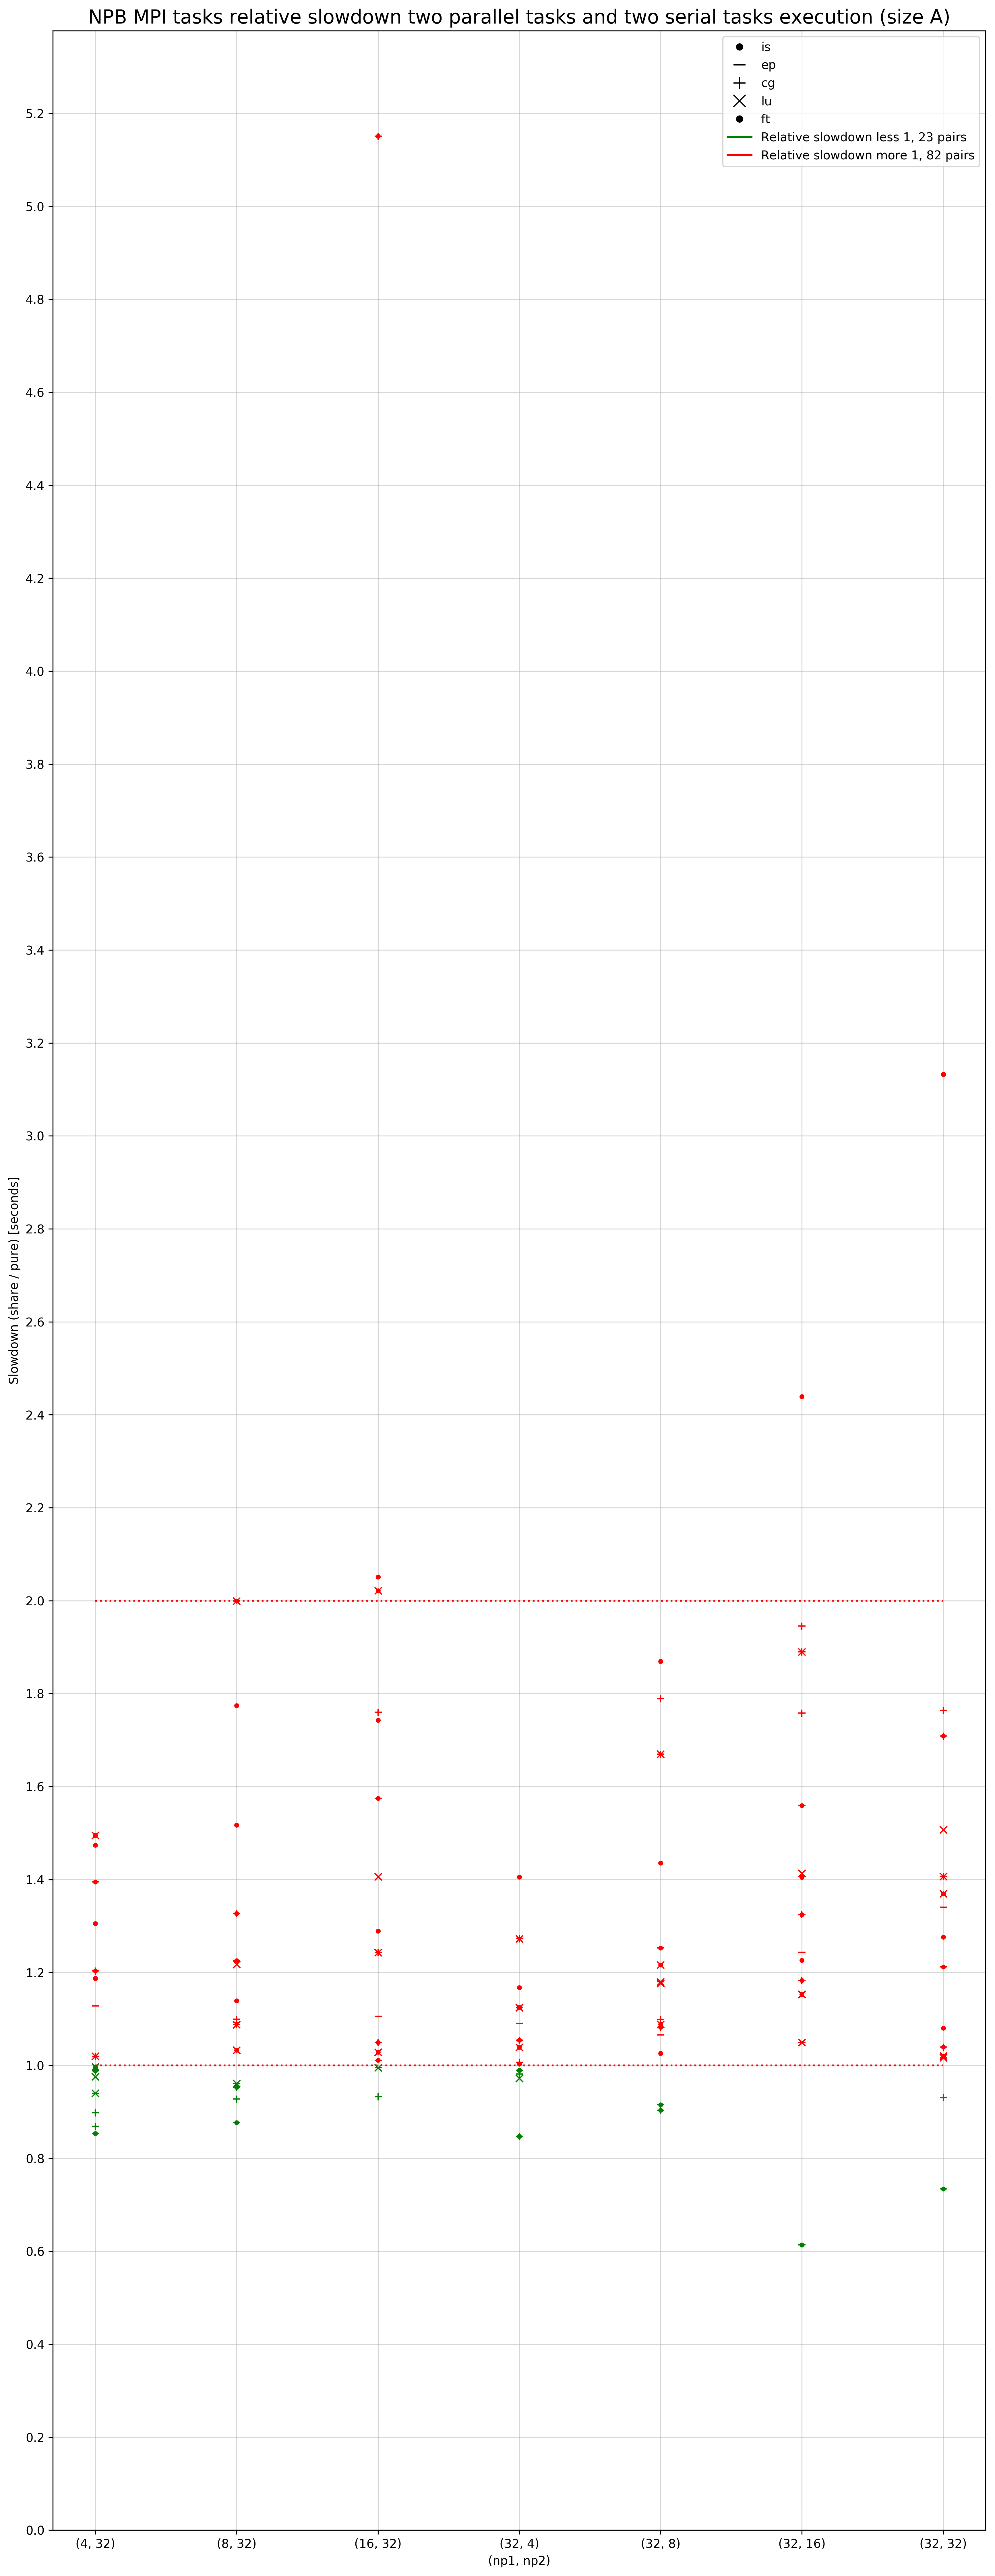

In [41]:
# Draw slowdown info
# Relative slowdown
# Calculate for each pair in experiments -> max(t1_sharing, t2_sharing) / (t1_pure + t2_pure)

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
%matplotlib inline


tasks = ["is", "ep", "cg", "lu", "ft"]
colors = {"is": "red", "ep": "blue", "cg": "orange", "lu": "black", "ft": "cyan"}
markers = {"is": ".", "ep": "_", "cg": "+", "lu": "x", "ft": "."}

# Figure configuration
fig = plt.figure(figsize=(12,30), dpi=300)
ax = fig.add_subplot(111)
plt.title('NPB MPI tasks relative slowdown two parallel tasks and two serial tasks execution (size A)', fontsize=16)

# Draw
# X_DOTS = [2, 5, 6, 7, 8] # index int list [(4,4), (4,8), ..., (16,16)]
X_DOTS = [3, 7, 11, 12, 13, 14, 15] # NOTE! For 32 threads only

green = 0
red = 0

for tasks_pair, procs in results_sharing.items():
    n = -1
    for procs_pair, t in procs.items():
        n += 1
        if (n not in X_DOTS):
            continue
        
        t1_p = results_pure[tasks_pair[0]]["A"][procs_pair[0]]
        t2_p = results_pure[tasks_pair[1]]["A"][procs_pair[1]]

        task1 = tasks_pair[0]
        task2 = tasks_pair[1]
        
        # TODO
        # remove double dots
        rel_sl1 = max(t[0], t[1]) / (t1_p + t2_p)
        rel_sl2 = max(t[0], t[1]) / (t1_p + t2_p)
        
        color = "black"
        if rel_sl1 < 1 and rel_sl2 < 1:
            color = "green"
            green += 1
        else:
            color = "red"
            red += 1
            
        ax.plot(X_DOTS.index(n), rel_sl1, color=color, marker=markers[task1])
        ax.plot(X_DOTS.index(n), rel_sl2, color=color, marker=markers[task2])

# Draw slowdown lines with factor 1 and 2
PROCS_PAIR = list(results_sharing[('is', 'is')].keys())
null_slowdown_x = np.linspace(0, len(X_DOTS)-1, num=2)
null_slowdown_y = np.zeros(2)
ax.plot(null_slowdown_x, null_slowdown_y+1, color="red", linestyle=":")

ax.plot(null_slowdown_x, null_slowdown_y+2, color="red", linestyle=":")

# Axes configuration
ax.set_xticks(np.arange(len(X_DOTS)))
ax.set_xticklabels([PROCS_PAIR[i] for i in X_DOTS])
ax.set_xlabel("(np1, np2)")
ax.set_ylabel("Slowdown (share / pure) [seconds]")


# Grid configuration
stepsize = 0.2
start, end = ax.get_ylim()
ax.yaxis.set_ticks(np.arange(0, end, stepsize))

ax.set_axisbelow(True)
ax.grid(which='both')
ax.grid(which='major', alpha=0.5)

# Form legend
legend_elements = []
for task in tasks:
    legend_elements.append(
        Line2D([], [], marker=markers[task], color="black", linestyle='None', label=task, markersize=10))

legend_elements.append(
        Line2D([0], [0], color="green", linestyle='-', label="Relative slowdown less 1, %d pairs" % green))
legend_elements.append(
        Line2D([0], [0], color="red", linestyle='-', label="Relative slowdown more 1, %d pairs" % red))

# Show figure
ax.legend(handles=legend_elements)
plt.tight_layout()
plt.show()
fig.savefig('./relative_slowdown_size_A_groups_%s.png' % str('_'.join(map(str, X_DOTS))), fmt='png')
plt.close(fig)
# plt.gcf().clear()